In [1]:
from ipnb_helpers import ExperimentReader, ScoreReader
import numpy as np
from pprint import pprint 
import itertools
import json
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [8, 5.33]
plt.rc('text', usetex=True)

In [2]:
#load datasets stats
with open("/scratch/users/rmormont/dataset_stats.json", "r", encoding="utf8") as file:
    dataset_stats = json.load(file)

In [32]:
# CONFIGURATION
dataset = "monuseg"

# which sparsities ?
all_configurations = {
    "glas": ([1.0, 0.99, 0.975, 0.95, 0.85, 0.8, 0.75, 0.6, 0.5, 0.25], [2, 4, 16, 24, 32, 40, 60]),
    "segpc": ([1.0, 0.95, 0.85, 0.8, 0.75, 0.60, 0.5, 0.25], [10, 20, 40, 50, 75, 100, 150, 200]),
    "monuseg": ([1.0, 0.95, 0.85, 0.8, 0.75, 0.60, 0.5, 0.975, 0.99, 0.25], [1, 3, 4, 5, 10, 15]),
} 
rrs, ncs = all_configurations[dataset]

# which metric
#metric = "test_hard_dice"
metric = "test_pxl_self_hard_dice"

# params 
all_params = {
    "glas": [{"weights_constant": "0.01"}, {"weights_constant": "0.5"}],
    "segpc": [{"weights_constant": "0.01"}, {"weights_constant": "0.5"}, {"weights_constant": "2.0"}],
    "monuseg": [{"weights_constant": "0.01"}, {"weights_constant": "0.5"}],
}

studied = all_params[dataset]

# plot type: rho, p_unknown
#x_stat = "rho"
x_stat = "p_unknown"

# for the base experiment 
base_params = {"no_distillation": 'False', "weights_mode": "constant", 'distil_target_mode': 'hard_dice'}



In [33]:
#HELPER FUNCTIONS
def make_score_reader_list(dataset, exp_type, metric, param_values, param="rr", **params):
    if param == "rr":
        param_values = ["{:0.4f}".format(v) for v in param_values]
    return [
        ScoreReader("{}-{}-{}-{}".format(dataset, exp_type, param, param_value), metric, dataset_stats, param, **params) 
        for param_value in param_values
    ]

def scorer_for_base_exp(dataset, exp_type, metric, param="rr", **params):
    return ScoreReader("{}-{}".format(dataset, exp_type), metric, dataset_stats, param, **params)


In [34]:
# STATIC BASELINES
bls_upper = ScoreReader("{}-baseline-upper".format(dataset), metric, dataset_stats)
bls_nosparse = ScoreReader("{}-baseline-nosparse".format(dataset), metric, dataset_stats)

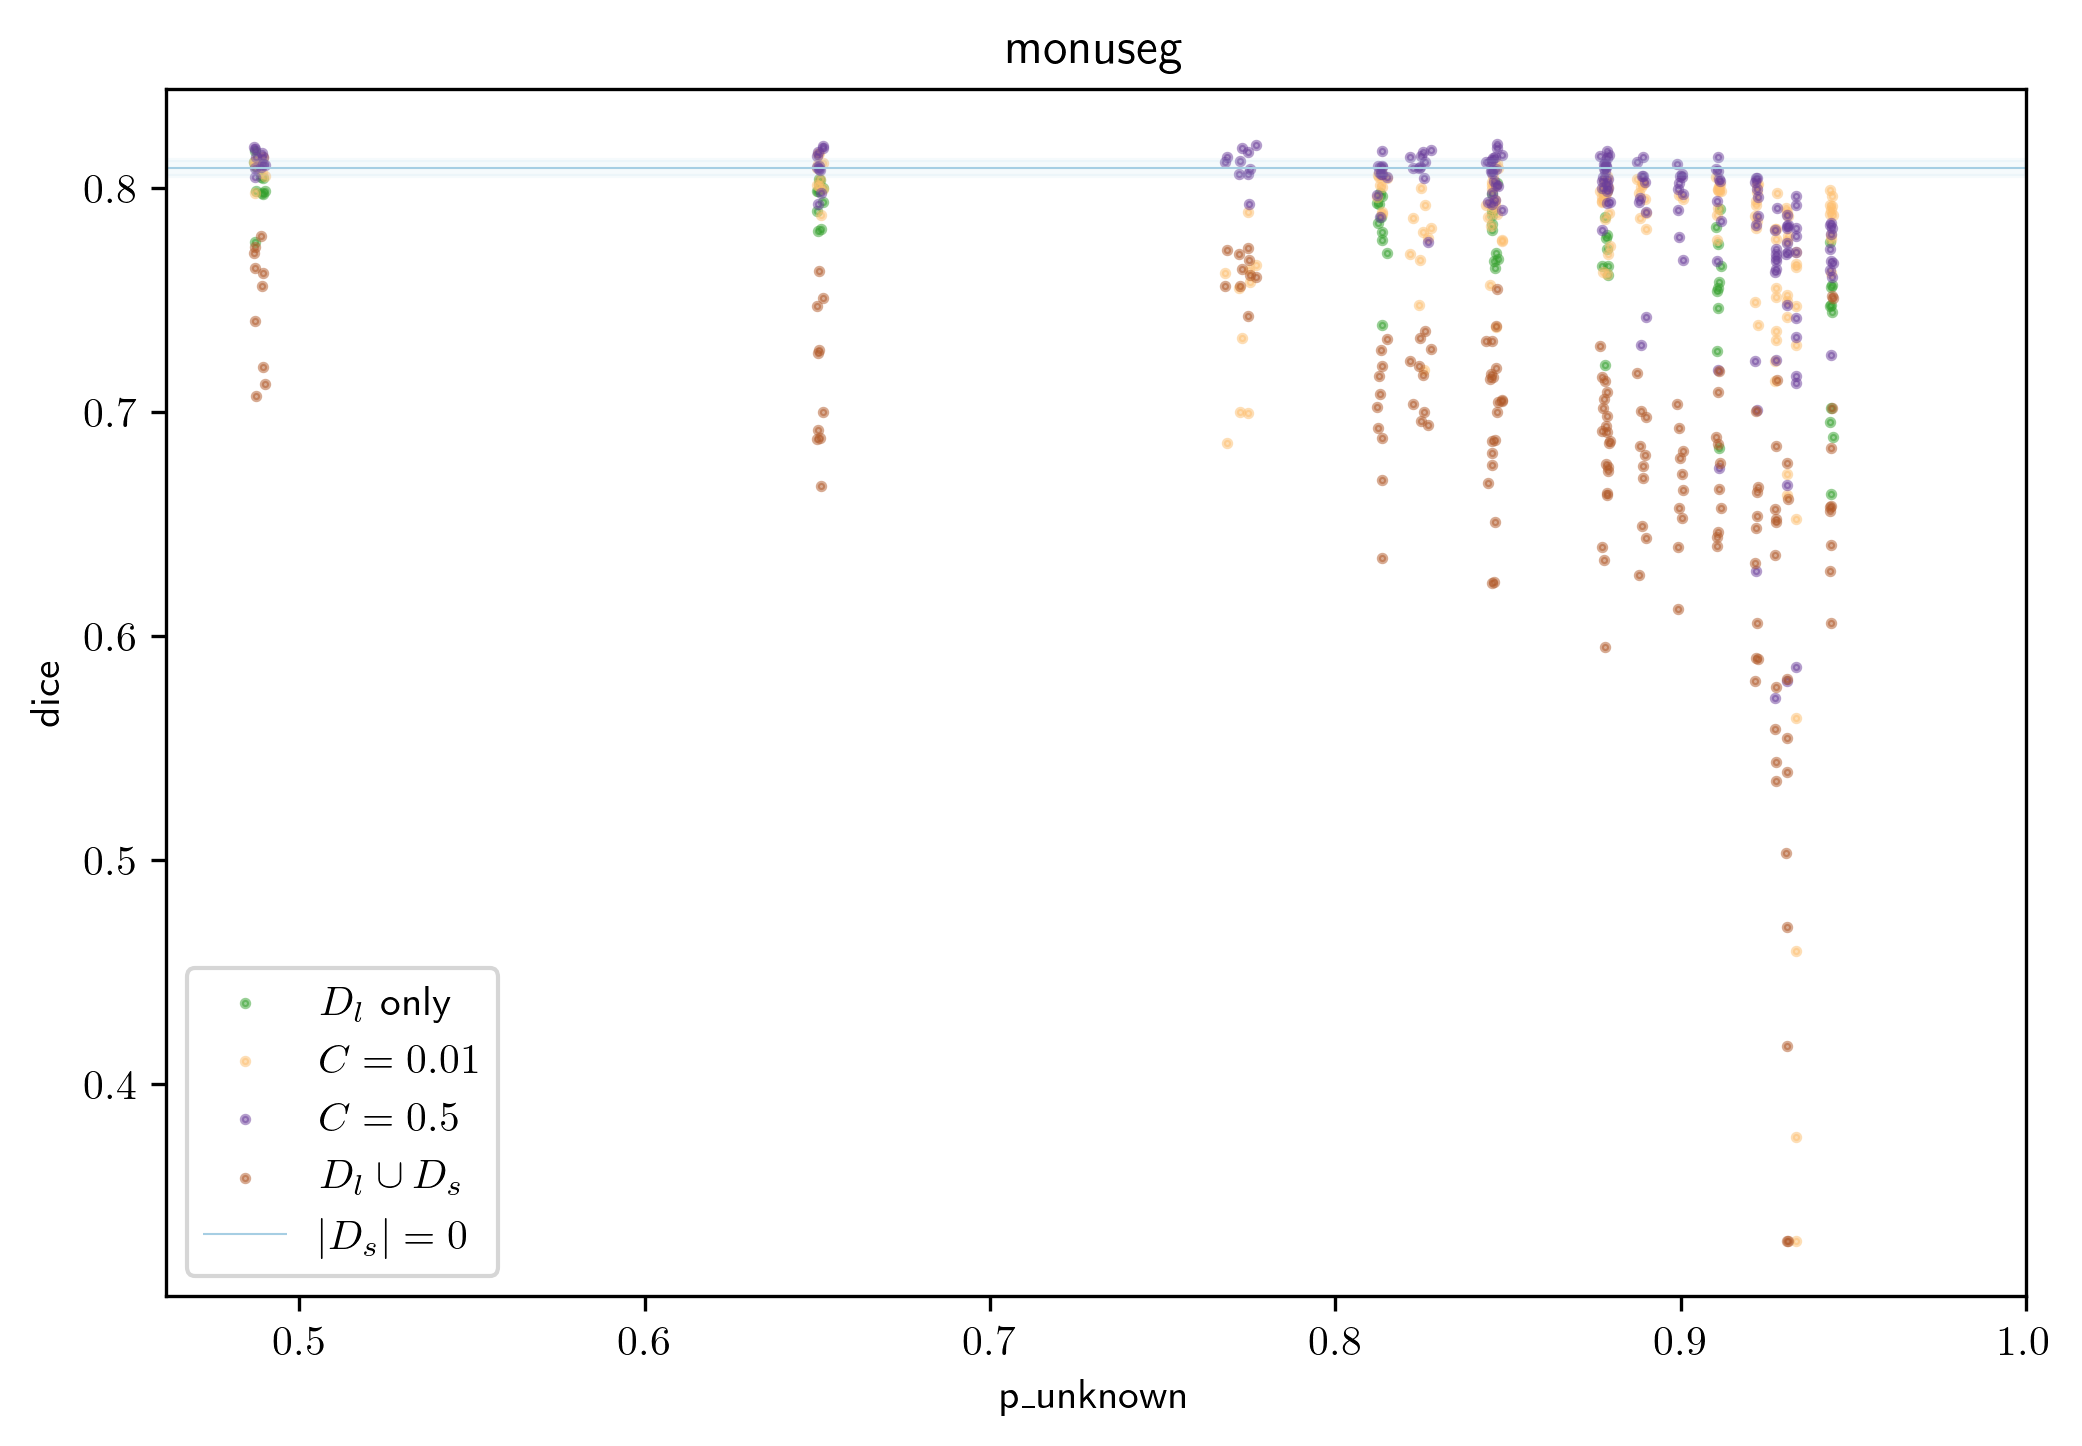

In [35]:
# PLOT over sparsity

et_strain = "self-train"
et_noself = "baseline-noself"
et_nosparse = "baseline-nosparse"


plt.figure()

# make scores list
readers_lists = list()

if x_stat != "rho":
    reader_nosparse = make_score_reader_list(dataset, et_nosparse, metric, ncs, param="nc") 
    reader_nosparse.append(scorer_for_base_exp(dataset, et_nosparse, metric, "nc"))
    readers_lists.append(("$D_l$ only", reader_nosparse))

for curr_params in studied:
    readers = make_score_reader_list(dataset, et_strain, metric, rrs, param="rr", **curr_params)
    readers.append(scorer_for_base_exp(dataset, et_strain, metric, **curr_params, **base_params))
    if x_stat != "rho":
        readers.extend(make_score_reader_list(dataset, et_strain, metric, ncs, param="nc", **curr_params))
    readers_lists.append(("$C={}$".format(curr_params["weights_constant"]), readers))

reader_noself = make_score_reader_list(dataset, et_noself, metric, rrs[1:], param="rr") 
reader_noself.append(scorer_for_base_exp(dataset, et_noself, metric))
if x_stat != "rho":
    reader_noself.extend(make_score_reader_list(dataset, et_noself, metric, ncs, param="nc"))
readers_lists.append(("$D_l \cup D_s$", reader_noself))

colors = iter(plt.get_cmap("Paired")(np.linspace(0, 1, (2 if x_stat == "rho" else 1) + len(readers_lists))))

reserved_colors = []
reserved_colors.append(next(colors))
if x_stat == "rho":
    reserved_colors.append(next(colors))

xmin, xmax = 1.0, 0.0

# offset for error bars
step = 0.0025
n_curves = len(readers_lists)
off_max = (n_curves - 1) * step / 2
off_min = - off_max
x_offsets = np.linspace(off_min, off_max, num=n_curves)

for i, (label, readers) in enumerate(readers_lists):
    curr_color = next(colors)
    if x_stat == "rho":
        x, y, y_std = map(np.array, zip(*[r.get_xy() for r in readers]))
        no_none = x > 0
        x, y, y_std = x[no_none], y[no_none], y_std[no_none]
        idx = np.argsort(x)
        plt.errorbar(x[idx] + x_offsets[i], y[idx], yerr=y_std[idx], marker="o", ms=3, elinewidth=0.5, linewidth=0.5, color=curr_color, label=label, capsize=2, alpha=0.8)
        xmin = np.minimum(xmin, np.min(x[idx] + x_offsets[i]))
        xmax = np.maximum(xmax, np.max(x[idx] + x_offsets[i]))
    else: 
        x, y = map(np.hstack, zip(*[r.get_scatter(x_stat) for r in readers]))
        plt.scatter(x, y, s=3, marker="o", color=curr_color, label=label, alpha=0.5)
        xmin = np.minimum(xmin, np.min(x))
        xmax = np.maximum(xmax, np.max(x))
        
        
xmin = xmin - 0.05 * (1 - xmin)
xmax = np.maximum(1.0, xmax)
plt.xlim(xmin, xmax)

upper_label = "$|D_s| = 0$"
upper_color =  reserved_colors[0]
upper = bls_upper
_, bl_upper_y, bl_upper_std = upper.get_xy()
plt.fill_between([xmin, xmax], 
             [bl_upper_y - bl_upper_std] * 2, [bl_upper_y + bl_upper_std] * 2, 
             color=upper_color, alpha=0.1)
plt.hlines(bl_upper_y, xmin, xmax, color=upper_color, label=upper_label, linewidth=0.5)

if x_stat == "rho":
    nosparse = bls_nosparse
    nosparse_label = "$D_l$ only"
    nosparse_color = reserved_colors[1]
    _, bl_nosparse_y, bl_nosparse_std = nosparse.get_xy()
    plt.fill_between([xmin, xmax], 
                     [bl_nosparse_y - bl_nosparse_std] * 2, [bl_nosparse_y + bl_nosparse_std] * 2, 
                     color=nosparse_color, alpha=0.1)
    plt.hlines(bl_nosparse_y, xmin, xmax, color=nosparse_color, label=nosparse_label, linewidth=0.75)

plt.title(r"{}".format(dataset) + (" $|D_l|=2$" if x_stat == "rho" else ""))
plt.xlabel(r"$\rho$" if x_stat == "rho" else x_stat.replace("_", "\_"))
plt.ylabel("dice")
plt.legend(loc="lower left")
#plt.ylim(0.6, 0.9)
plt.show()
plt.close()
    


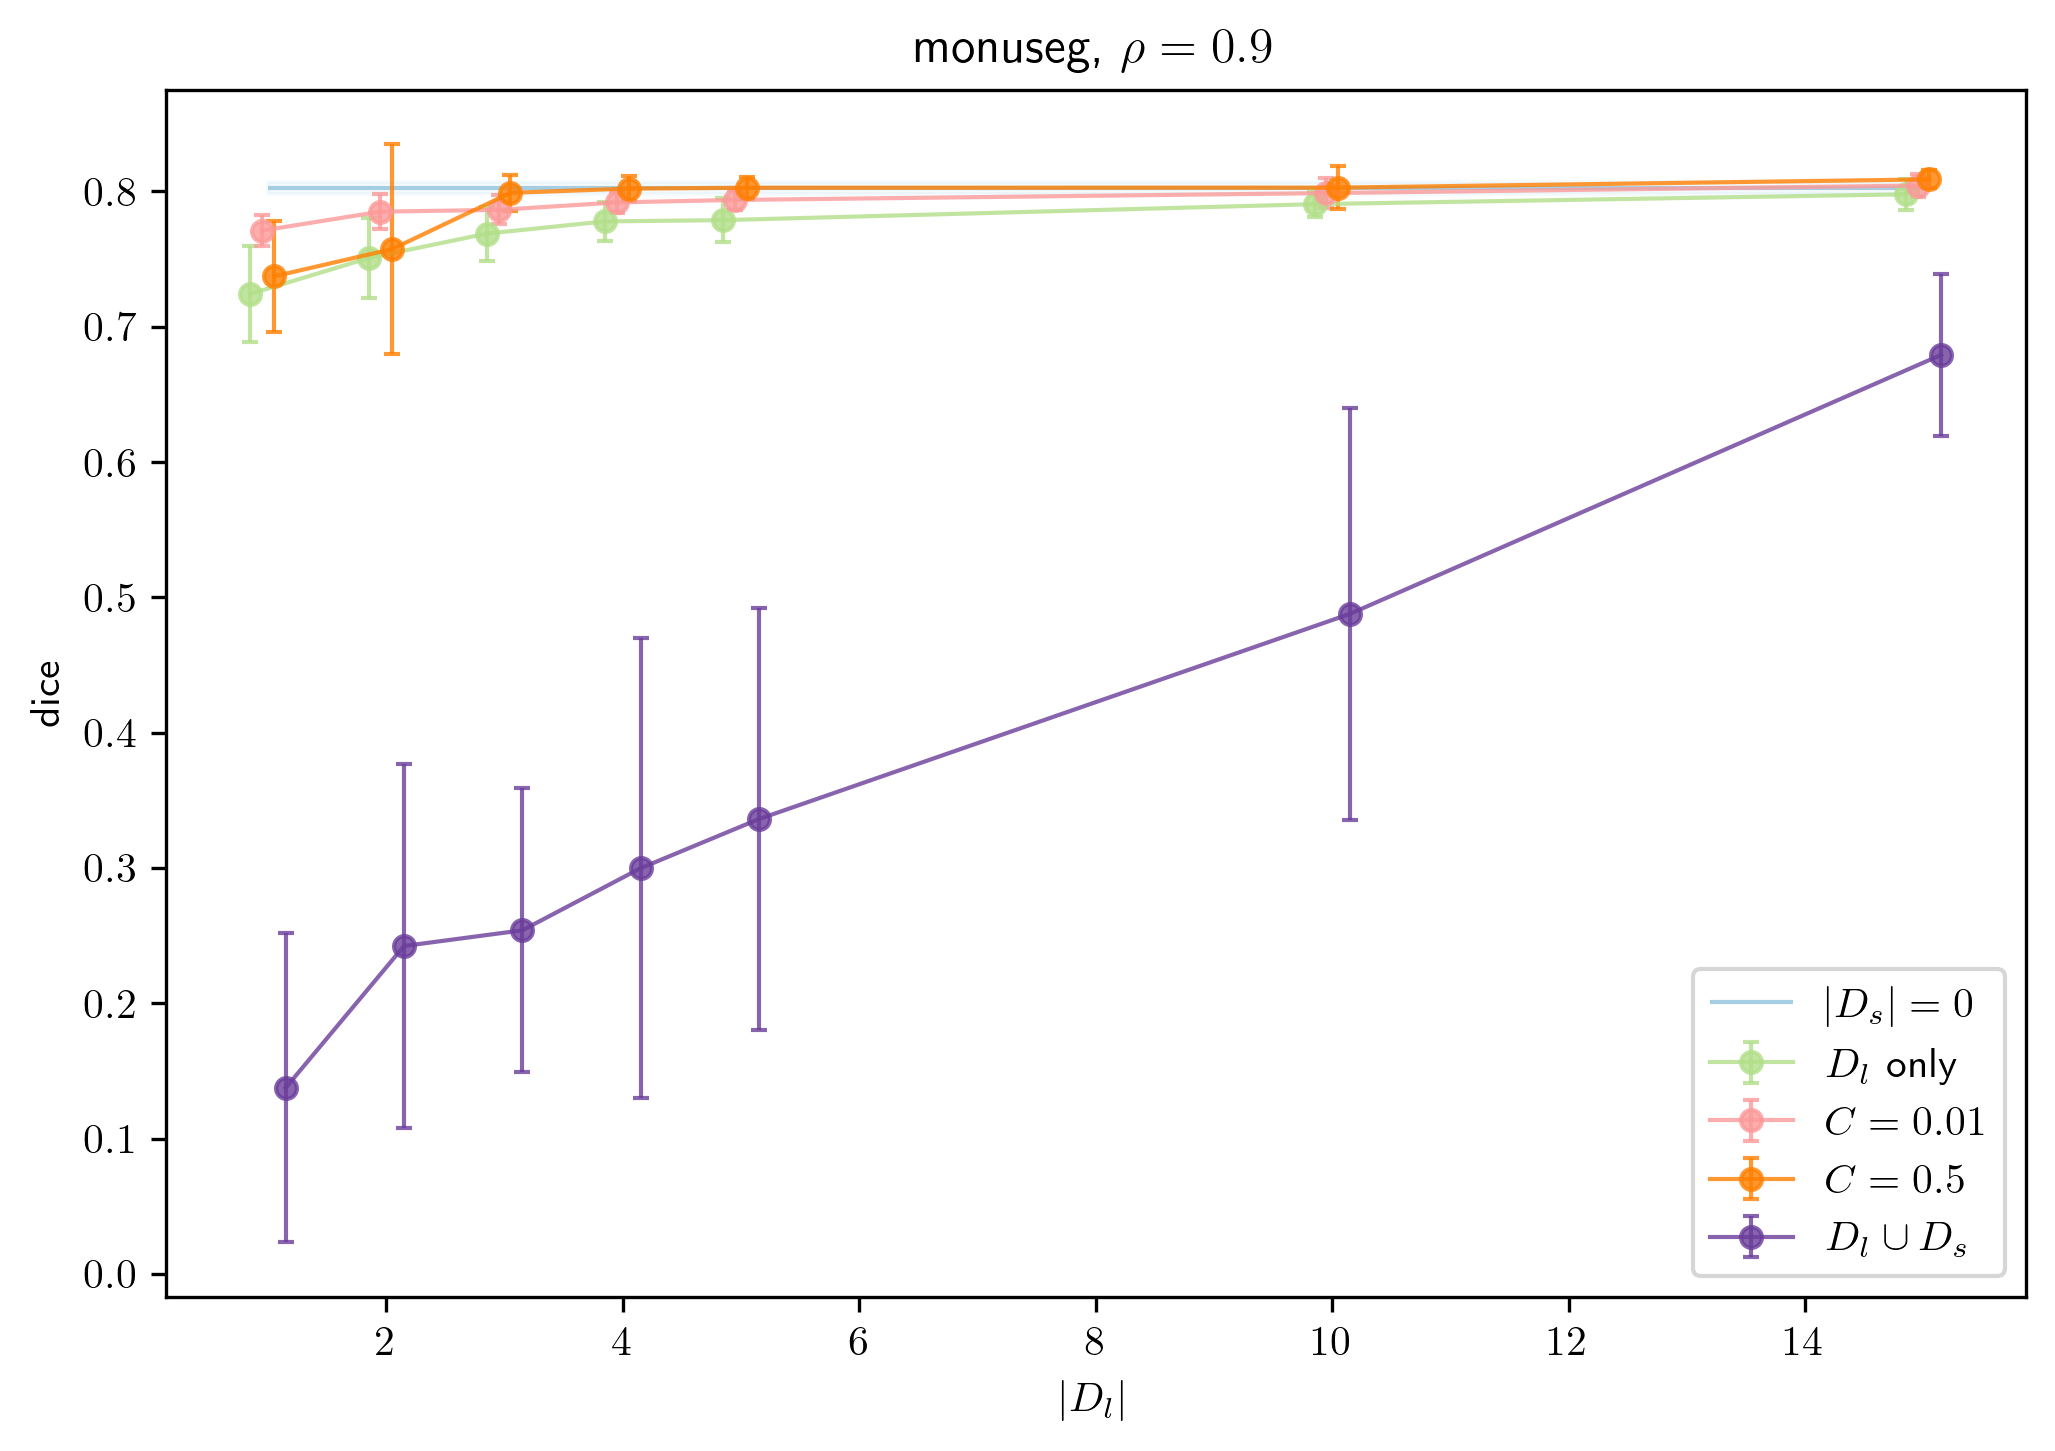

In [27]:

plt.figure()
plt.title(r"{}, $\rho=0.9$".format(dataset))

# make scores list
readers_lists = list()

reader_nosparse = make_score_reader_list(dataset, et_nosparse, metric, ncs, param="nc") 
reader_nosparse.append(scorer_for_base_exp(dataset, et_nosparse, metric, "nc"))
readers_lists.append(("$D_l$ only", reader_nosparse))

reader_0_01 = make_score_reader_list(dataset, et_strain, metric, ncs, param="nc", **{"weights_constant": "0.01"})
reader_0_01.append(scorer_for_base_exp(dataset, et_strain, metric, "nc", weights_constant="0.01", **base_params))
readers_lists.append(("$C=0.01$", reader_0_01))

reader_0_50 = make_score_reader_list(dataset, et_strain, metric, ncs, param="nc", **{"weights_constant": "0.5"})
reader_0_50.append(scorer_for_base_exp(dataset, et_strain, metric, "nc", weights_constant="0.5", **base_params))
readers_lists.append(("$C=0.5$", reader_0_50))

reader_noself = make_score_reader_list(dataset, et_noself, metric, ncs, param="nc") 
reader_noself.append(scorer_for_base_exp(dataset, et_noself, metric, "nc"))
readers_lists.append(("$D_l \cup D_s$", reader_noself))
colors = iter(plt.get_cmap("Paired")(np.linspace(0, 1, 2 + len(readers_lists))))

xmin, xmax = np.min(ncs), np.max(ncs)
upper_label = "$|D_s| = 0$"
upper_color = next(colors)
upper = bls_upper
_, bl_upper_y, bl_upper_std = upper.get_xy()
plt.fill_between([xmin, xmax], 
             [bl_upper_y - bl_upper_std] * 2, [bl_upper_y + bl_upper_std] * 2, 
             color=upper_color, alpha=0.1)
plt.hlines(bl_upper_y, xmin, xmax, color=upper_color, label=upper_label, linewidth=1)

# offset for error bars
step = 0.1
n_curves = len(readers_lists)
off_max = (n_curves - 1) * step / 2
off_min = - off_max
x_offsets = np.linspace(off_min, off_max, num=n_curves)

for i, (label, readers) in enumerate(readers_lists):
    x, y, y_std = map(np.array, zip(*[r.get_xy() for r in readers]))
    no_none = x > 0
    x, y, y_std = x[no_none], y[no_none], y_std[no_none]
    idx = np.argsort(x)
    curr_color = next(colors)
    plt.errorbar(x[idx] + x_offsets[i], y[idx], yerr=y_std[idx], marker="o", ms=5, elinewidth=1, linewidth=1, color=curr_color, label=label, capsize=2, alpha=0.8)

plt.xlabel(r"$|D_l|$")
plt.ylabel("dice")
plt.legend(loc="lower right")
# plt.ylim(0.7, 0.85)
plt.show()
plt.close()